## Preprocessing steps for Wind Turbine data comparison. As credit, part of these preprocessing steps and feature analysis of this notebook were directly taken from here https://www.kaggle.com/code/akdagmelih/wind-turbine-power-prediction-gbtregressor-pyspark

In [39]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [40]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')

## Importing Pyspark

In [42]:
# Importing pyspark libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.conf import SparkConf
from pyspark import SparkContext
from pyspark.sql.functions import percent_rank
from pyspark.sql import Window
# Configuration of Spark Session
spark = SparkSession.builder.appName("wind_turbine_project").getOrCreate()
spark.version

'3.3.1'

In [43]:
directory_path = os.getcwd()
directory_path

'/content'

In [44]:
data_directory_path = os.getcwd()

data_path = os.path.join(data_directory_path,"Data", "wind_turbine_data.csv")
wind_pandas_df = pd.read_csv(data_path)
spark_df = spark.createDataFrame(wind_pandas_df)
wind_pandas_df

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913


In [45]:
# Caching the dataset
spark_df.cache()
# Converting all the column names to lower case
spark_df = spark_df.toDF(*[c.lower() for c in spark_df.columns])
print('Show the first 5 rows')
print(spark_df.show(5))
print()
print('What are the variable data types?')
print(spark_df.printSchema())
print()
print('How many observations do we have?')
print(spark_df.count())

Show the first 5 rows
+----------------+-------------------+----------------+-----------------------------+------------------+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|
+----------------+-------------------+----------------+-----------------------------+------------------+
|01 01 2018 00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|
|01 01 2018 00:10|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|
|01 01 2018 00:20|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|
|01 01 2018 00:30|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|
|01 01 2018 00:40|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|
+----------------+-------------------+----------------+-----------------------------+------------------+
only showing top 5 rows

None

Wh

In [46]:
from pyspark.sql.functions import substring
spark_df = spark_df.withColumn("month", substring("date/time", 4,2))
spark_df = spark_df.withColumn("day", substring("date/time",1,2))
spark_df = spark_df.withColumn("hour", substring("date/time", 12,2))
spark_df = spark_df.withColumn("minute", substring("date/time", 15,2))


from pyspark.sql.types import IntegerType
spark_df = spark_df.withColumn('month', spark_df.month.cast(IntegerType()))
spark_df = spark_df.withColumn('day', spark_df.day.cast(IntegerType()))
spark_df = spark_df.withColumn('hour', spark_df.hour.cast(IntegerType()))
spark_df = spark_df.withColumn('minute', spark_df.minute.cast(IntegerType()))

print(spark_df.show(30))

+----------------+-------------------+----------------+-----------------------------+------------------+-----+---+----+------+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|month|day|hour|minute|
+----------------+-------------------+----------------+-----------------------------+------------------+-----+---+----+------+
|01 01 2018 00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|    1|  1|   0|     0|
|01 01 2018 00:10|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|    1|  1|   0|    10|
|01 01 2018 00:20|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|    1|  1|   0|    20|
|01 01 2018 00:30|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|    1|  1|   0|    30|
|01 01 2018 00:40|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|    1| 

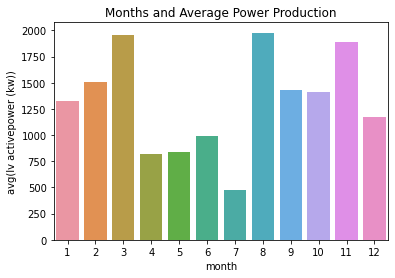

In [47]:
# Average power production by month
monthly = spark_df.groupby('month').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
sns.barplot(x='month', y='avg(lv activepower (kw))', data=monthly)
plt.title('Months and Average Power Production');

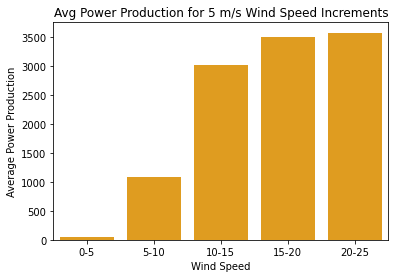

In [48]:
# Finding average power production for 5 m/s wind speed increments
wind_speed = []
avg_power = []
for i in [0,5,10,15,20]:
    avg_value = spark_df.filter((spark_df['wind speed (m/s)'] > i) 
                                & (spark_df['wind speed (m/s)'] <= i+5))\
                                .agg({'lv activepower (kw)':'mean'}).collect()[0][0] 
    avg_power.append(avg_value)
    wind_speed.append(str(i) + '-' + str(i+5))

sns.barplot(x=wind_speed, y=avg_power, color='orange')
plt.title('Avg Power Production for 5 m/s Wind Speed Increments')
plt.xlabel('Wind Speed')
plt.ylabel('Average Power Production');

,wind speed (m/s),theoretical_power_curve (kwh),lv activepower (kw)
18,1.757177,0.0,0.0
2044,1.475465,0.0,0.0
462,2.328350,0.0,0.0
3591,1.471564,0.0,0.0
6148,1.724973,0.0,0.0


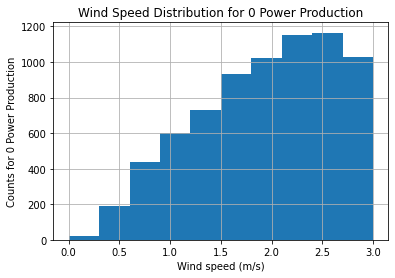

In [49]:
# Filter the big data where the real and theoritical power productions are equal to 0
zero_theo_power = spark_df.filter((spark_df['lv activepower (kw)'] == 0)
                                  & (spark_df['theoretical_power_curve (kwh)'] == 0)).toPandas()

display(zero_theo_power[['wind speed (m/s)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']].sample(5))

# Let's see the wind speed distribution for 0 power production
zero_theo_power['wind speed (m/s)'].hist()
plt.title('Wind Speed Distribution for 0 Power Production')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Counts for 0 Power Production');

In [50]:
# Observations for the wind speed > 3m/s and power production = 0, 
# While theoritically there should be power production
zero_power = spark_df.filter((spark_df['lv activepower (kw)'] == 0)
                            & (spark_df['theoretical_power_curve (kwh)'] != 0)
                            & (spark_df['wind speed (m/s)'] > 3)).toPandas()
display(zero_power.head())
print('No of Observations (while Wind Speed > 3 m/s and Power Production = 0): ', len(zero_power))

,date/time,lv activepower (kw),wind speed (m/s),theoretical_power_curve (kwh),wind direction (°),month,day,hour,minute
0,03 01 2018 15:40,0.0,3.743307,83.986265,245.068207,1,3,15,40
1,03 01 2018 16:40,0.0,3.034003,17.180593,221.086502,1,3,16,40
2,03 01 2018 16:50,0.0,3.197354,25.431221,232.679596,1,3,16,50
3,03 01 2018 17:00,0.0,3.907811,110.979604,241.973099,1,3,17,0
4,04 01 2018 13:50,0.0,3.441704,45.742725,79.094109,1,4,13,50


No of Observations (while Wind Speed > 3 m/s and Power Production = 0):  3497


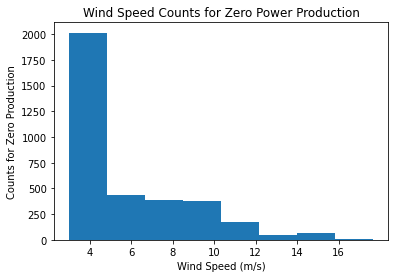

In [51]:
zero_power['wind speed (m/s)'].plot.hist(bins=8)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Counts for Zero Production')
plt.title('Wind Speed Counts for Zero Power Production')
plt.xticks(ticks=np.arange(4,18,2));

In [52]:
# Excluding the observations meeting the filter criterias 
spark_df = spark_df.filter(~((spark_df['lv activepower (kw)'] == 0)
                            & (spark_df['theoretical_power_curve (kwh)'] != 0)
                            & (spark_df['wind speed (m/s)'] > 3)))

In [53]:
# Create a pandas df for visualization
wind_speed = spark_df.select('wind speed (m/s)').toPandas()

# Defining the quantiles and interquantile range
Q1 = wind_speed['wind speed (m/s)'].quantile(0.25)
Q3 = wind_speed['wind speed (m/s)'].quantile(0.75)
IQR = Q3-Q1
# Defining the lower and upper threshold values
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

print('Quantile (0.25): ', Q1, '  Quantile (0.75): ', Q3)
print('Lower threshold: ', lower, ' Upper threshold: ', upper)

Quantile (0.25):  4.45584678649902   Quantile (0.75):  10.4771900177001
Lower threshold:  -4.576168060302599  Upper threshold:  19.50920486450172


In [54]:
# Fancy indexing for outliers
outlier_tf = (wind_speed['wind speed (m/s)'] < lower) | (wind_speed['wind speed (m/s)'] > upper)

print('Total Number of Outliers: ', len(wind_speed['wind speed (m/s)'][outlier_tf]))
print('--'*15)
print('Some Examples of Outliers:')
print(wind_speed['wind speed (m/s)'][outlier_tf].sample(10))

Total Number of Outliers:  407
------------------------------
Some Examples of Outliers:
3412     19.759399
3533     23.056530
6657     19.819309
42810    19.585171
3243     20.240870
3537     20.741369
2123     21.599480
8906     20.786770
6947     20.367630
2094     20.408730
Name: wind speed (m/s), dtype: float64


In [55]:
spark_df.select('wind speed (m/s)', 'lv activepower (kw)')\
.filter(spark_df['wind speed (m/s)'] >= 19)\
.agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|      3566.4634427974706|
+------------------------+



In [56]:
from pyspark.sql import functions as F
spark_df = spark_df.withColumn('wind speed (m/s)', 
                               F.when(F.col('wind speed (m/s)') > 19.447, 19)
                               .otherwise(F.col('wind speed (m/s)')))
spark_df.count()

47033

In [57]:
# High level power production
spark_df.filter(((spark_df['month'] == 3) | (spark_df['month'] == 8) | (spark_df['month'] == 11)) 
                & ((spark_df['hour'] >= 16) | (spark_df['hour'] <= 24)) 
                & ((spark_df['wind direction (°)'] > 0) | (spark_df['wind direction (°)'] < 90))
                & ((spark_df['wind direction (°)'] > 180) | (spark_df['wind direction (°)'] < 225))
               ).agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|      2013.4446757880403|
+------------------------+



In [58]:
# Low level power production
spark_df.filter((spark_df['month'] == 7) 
                & ((spark_df['hour'] >= 9) | (spark_df['hour'] <= 11)) 
                & ((spark_df['wind direction (°)'] > 90) | (spark_df['wind direction (°)'] < 160))
               ).agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|       503.1644205414878|
+------------------------+



## Preparing for ML

In [59]:
# Preparing the independent variables (Features)
from pyspark.ml.feature import VectorAssembler

# Converting lv activepower (kw) variable as label
spark_df = spark_df.withColumn('label', spark_df['lv activepower (kw)'])
spark_df = spark_df.drop('theoretical_power_curve (kwh)')

In [60]:
spark_timestamp_df = spark_df.withColumn("timestamp",to_timestamp(col("date/time"),"dd MM yyyy HH:mm")).drop("date/time", "lv activepower (kw)")
spark_timestamp_df.count()

47033

In [61]:
spark_timestamp_df.columns

['wind speed (m/s)',
 'wind direction (°)',
 'month',
 'day',
 'hour',
 'minute',
 'label',
 'timestamp']

In [62]:
df_pandas = spark_timestamp_df.toPandas()
rename_dictionary = {'wind speed (m/s)' : 'wind_speed', 'wind direction (°)' : 'wind_direction'}
df_pandas.rename(columns=rename_dictionary, inplace=True)

In [63]:
df_pandas.columns

Index(['wind_speed', 'wind_direction', 'month', 'day', 'hour', 'minute',
       'label', 'timestamp'],
      dtype='object')

## Standard Scaling

In [64]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
columns_to_scale = ["wind_speed","wind_direction","month","day","hour", "minute", "label"]
df_scaled = df_pandas.copy()
scaling_dict = {}
for col in columns_to_scale:
    df_scaled[col] = scaler.fit_transform(np.array(df_scaled[col]).reshape(-1,1))
    scaling_dict[col] = [scaler.mean_, np.sqrt(scaler.var_)]
df_scaled

,wind_speed,wind_direction,month,day,hour,minute,label,timestamp
0,-0.562532,1.469800,-1.669781,-1.682987,-1.665854,-1.462890,-0.782822,2018-01-01 00:00:00
1,-0.477149,1.563055,-1.669781,-1.682987,-1.665854,-0.877278,-0.726511,2018-01-01 00:10:00
2,-0.585082,1.605374,-1.669781,-1.682987,-1.665854,-0.291667,-0.839094,2018-01-01 00:20:00
3,-0.480105,1.591281,-1.669781,-1.682987,-1.665854,0.293945,-0.752575,2018-01-01 00:30:00
4,-0.499445,1.531056,-1.669781,-1.682987,-1.665854,0.879557,-0.782361,2018-01-01 00:40:00
...,...,...,...,...,...,...,...,...
47028,0.879179,-0.466141,1.625784,1.790039,1.643251,-0.877278,1.190860,2018-12-31 23:10:00
47029,-0.084230,-0.427745,1.625784,1.790039,1.643251,-0.291667,0.213444,2018-12-31 23:20:00
47030,0.176704,-0.420412,1.625784,1.790039,1.643251,0.293945,0.608155,2018-12-31 23:30:00
47031,0.410022,-0.425207,1.625784,1.790039,1.643251,0.879557,0.848446,2018-12-31 23:40:00


In [65]:
scaling_dict

{'wind_speed': [array([7.68860482]), array([4.22601644])],
 'wind_direction': [array([123.72129768]), array([92.71575796])],
 'month': [array([6.57342717]), array([3.33782008])],
 'day': [array([15.53764378]), array([8.63800029])],
 'hour': [array([11.57855123]), array([6.95051785])],
 'minute': [array([24.98054557]), array([17.07616514])],
 'label': [array([1404.91334361]), array([1309.19416897])]}

In [66]:
spark_timestamp_df.show()

+----------------+------------------+-----+---+----+------+----------------+-------------------+
|wind speed (m/s)|wind direction (°)|month|day|hour|minute|           label|          timestamp|
+----------------+------------------+-----+---+----+------+----------------+-------------------+
|5.31133604049682|  259.994903564453|    1|  1|   0|     0|380.047790527343|2018-01-01 00:00:00|
|5.67216682434082|   268.64111328125|    1|  1|   0|    10| 453.76919555664|2018-01-01 00:10:00|
|5.21603679656982|  272.564788818359|    1|  1|   0|    20|306.376586914062|2018-01-01 00:20:00|
|5.65967416763305|  271.258087158203|    1|  1|   0|    30|419.645904541015|2018-01-01 00:30:00|
|5.57794094085693|  265.674285888671|    1|  1|   0|    40|380.650695800781|2018-01-01 00:40:00|
|5.60405206680297|   264.57861328125|    1|  1|   0|    50|402.391998291015|2018-01-01 00:50:00|
|5.79300785064697|  266.163604736328|    1|  1|   1|     0|447.605712890625|2018-01-01 01:00:00|
|5.30604982376098|  257.949493

## Saving results

In [67]:
df_scaled.to_csv(os.path.join(data_directory_path, "Data", "scaled_wind_data.csv"), index=False)
pd.DataFrame(scaling_dict).to_csv(os.path.join(data_directory_path, "Data", "scaling_df.csv"), index=False)